## Libraries

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Typing
from typing import List

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, KFold

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVR, SVC

## 1 Loading the Data Pipeline

In [2]:
# Load the data from the CSV file
df = pd.read_csv('C:/Users/Nadir/Desktop/housing.csv')

# Fill NaN values in the 'total_bedrooms' column with the mean value
mean_total_bedrooms = df['total_bedrooms'].mean(skipna=True)
df['total_bedrooms'] = df['total_bedrooms'].fillna(mean_total_bedrooms).astype(int)

# Function to apply one-hot encoding to a column and merge it back to the DataFrame
def apply_one_hot_encoding(df, column):
    one_hot_encoded = pd.get_dummies(df[column], prefix=column)
    one_hot_encoded = one_hot_encoded.astype(int)
    df = pd.concat([df, one_hot_encoded], axis=1)
    df.drop(column, axis=1, inplace=True)
    return df

# Apply one-hot encoding to 'ocean_proximity'
df = apply_one_hot_encoding(df, 'ocean_proximity')

# Moving 'median_house_value' column to the last position
cols = list(df.columns)
cols.remove('median_house_value')  # Remove 'median_house_value' from the list of columns
cols.append('median_house_value')  # Append 'median_house_value' to the end of the list
df = df[cols]

# Standard scale the selected columns
columns_to_scale = df.columns[:-1]
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Display the DataFrame
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-1.327835,1.052548,0.982143,-0.804819,-0.975207,-0.974429,-0.977033,2.344766,-0.891156,-0.681889,-0.015566,2.830742,-0.384466,452600.0
1,-1.322844,1.043185,-0.607019,2.045890,1.355109,0.861439,1.669961,2.332238,-0.891156,-0.681889,-0.015566,2.830742,-0.384466,358500.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.829711,-0.820777,-0.843637,1.782699,-0.891156,-0.681889,-0.015566,2.830742,-0.384466,352100.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.722378,-0.766028,-0.733781,0.932968,-0.891156,-0.681889,-0.015566,2.830742,-0.384466,341300.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.615046,-0.759847,-0.629157,-0.012881,-0.891156,-0.681889,-0.015566,2.830742,-0.384466,342200.0


## 2 Data Splitting

In [3]:
# Assuming df is your DataFrame
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42)

## 3 Model Selection

In [4]:
def evaluate_models(X_train, y_train, X_test, y_test) -> pd.DataFrame:
    """  
    Evaluate different classification models and compare their performance.

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Testing features.
    y_test (array-like): Testing labels.

    Returns:
    pd.DataFrame: A DataFrame containing model names, training and testing performance metrics.
    """

    # Initialize models
    models = [
        ('SVR', SVR()),
        ('Logistic Regression', LinearRegression()),
        ('Decision Tree', DecisionTreeRegressor()),
        ('Random Forest', RandomForestRegressor()),
        ('XGBRegressor', XGBRegressor())
    ]
    
    # Initialize result DataFrame
    result = pd.DataFrame(columns=['Model', 'Train_MSE', 'Train_MAE', 'Train_R2', 'Test_MSE', 'Test_MAE', 'Test_R2'])
    
    for model_name, model in models:
        
        if model_name=="XGBRegressor":
            # Train the model
            model.fit(X_train.values, y_train)
            
            # Cross-validation
            kfold = StratifiedKFold(n_splits=5)
            cross_val_MSE = -cross_val_score(model, X_train.values, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()
            cross_val_MAE = -cross_val_score(model, X_train.values, y_train, cv=kfold, scoring='neg_mean_absolute_error').mean()
            cross_val_R2 = cross_val_score(model, X_train.values, y_train, cv=kfold, scoring='r2').mean()
        
            # Test the model
            predictions = model.predict(X_test.values)
            test_MSE = mean_squared_error(y_test, predictions)
            test_MAE = mean_absolute_error(y_test, predictions)
            test_R2 = r2_score(y_test, predictions)
        else:
            # Train the model
            model.fit(X_train, y_train)
            
            # Cross-validation
            kfold = StratifiedKFold(n_splits=5)
            cross_val_MSE = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()
            cross_val_MAE = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error').mean()
            cross_val_R2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2').mean()

            # Test the model
            predictions = model.predict(X_test)
            test_MSE = mean_squared_error(y_test, predictions)
            test_MAE = mean_absolute_error(y_test, predictions)
            test_R2 = r2_score(y_test, predictions)
        
        # Store results
        result.loc[len(result)] = [model_name, cross_val_MSE, cross_val_MAE, cross_val_R2, test_MSE, test_MAE, test_R2]
    return result

evaluate_models(X_train, y_train, X_test, y_test)

C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\s

,Model,Train_MSE,Train_MAE,Train_R2,Test_MSE,Test_MAE,Test_R2
0,SVR,1.401151e+10,88066.712833,-0.050157,1.383869e+10,87666.531736,-0.045836
1,Logistic Regression,4.739693e+09,49740.367628,0.644746,4.793339e+09,50329.542503,0.637751
2,Decision Tree,4.912853e+09,44718.730233,0.629233,4.618757e+09,43028.299612,0.650945
3,Random Forest,2.461458e+09,32515.705872,0.815392,2.409004e+09,31753.934393,0.817944
4,XGBRegressor,2.343220e+09,32206.874903,0.824381,2.282918e+09,31625.092371,0.827472


XGBoostRegressor it is!
## 4 Model Tuning (XGBoostRegressor)

In [5]:
# Initialize a Random Forest Classifier
xgbr_model = XGBRegressor()


# Fine-tuning parameters
param_grid = {
    'max_depth': [3, 6, 9],  # More values for max_depth
    'subsample': [0.8, 1.0, 1.2],  # More values for subsample
    'n_estimators': [100, 200, 300],  # More values for n_estimators
    'learning_rate': [0.1, 0.01, 0.001],  # More values for learning_rate
    'min_child_weight': [1, 5, 10],  # More values for min_child_weight
    'random_state': [42],  # Fixed random state for reproducibility
    'reg_alpha': [0, 0.1, 0.01],  # More values for reg_alpha
    'reg_lambda': [1, 0.5, 0.01]  # More values for reg_lambda
}

# Initialize Stratified K-Fold cross-validation
kfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(estimator=xgbr_model, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train.values,y_train)

# Access the best estimator directly
best_estimator_params = grid_search.best_estimator_.get_params()
best_estimator_params

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3645 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nadir\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**k

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 9,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [6]:
# Now you can create a new RandomForestClassifier using the best parameters
best_xgbr_model = XGBRegressor(**best_estimator_params)
best_xgbr_model.fit(X_train.values,y_train)

# Training set
kfold = StratifiedKFold(n_splits=5)
cross_val_MSE = -cross_val_score(best_xgbr_model, X_train.values, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()
cross_val_MAE = -cross_val_score(best_xgbr_model, X_train.values, y_train, cv=kfold, scoring='neg_mean_absolute_error').mean()
cross_val_R2 = cross_val_score(best_xgbr_model, X_train.values, y_train, cv=kfold, scoring='r2').mean()

# Test set
predictions = best_xgbr_model.predict(X_test.values)
test_MSE = mean_squared_error(y_test, predictions)
test_MAE = mean_absolute_error(y_test, predictions)
test_R2 = r2_score(y_test, predictions)


print(f"Train_MSE: {cross_val_MSE:.4f}")
print(f"Train_MAE: {cross_val_MAE:.4f}")
print(f"Train_R2: {cross_val_R2:.4f}")
print(f"Test_MSE: {test_MSE:.4f}")
print(f"Test_MAE: {test_MAE:.4f}")
print(f"Test_R2: {test_R2:.4f}")

C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Nadir\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Train_MSE: 2239133050.2126
Train_MAE: 30660.6997
Train_R2: 0.8322
Test_MSE: 2134145264.7314
Test_MAE: 29942.7115
Test_R2: 0.8387


In [7]:
# Whole set
predictions = best_xgbr_model.predict(X.values)
MSE = mean_squared_error(y, predictions)
MAE = mean_absolute_error(y, predictions)
R2 = r2_score(y, predictions)

df['predicted_values'] = predictions

print('MSE', MSE)
print('MAE', MAE)
print('R2', R2)

MSE 592010263.9511008
MAE 12253.322007668665
R2 0.9555397746585519


In [8]:
df[["median_house_value", "predicted_values"]].iloc[:50]

,median_house_value,predicted_values
0,452600.0,443662.531250
1,358500.0,365070.343750
2,352100.0,367112.375000
3,341300.0,350204.937500
4,342200.0,331469.375000
5,269700.0,262846.156250
6,299200.0,253227.843750
7,241400.0,248168.953125
8,226700.0,211362.343750
9,261100.0,260879.640625


## 6 Feature Importance

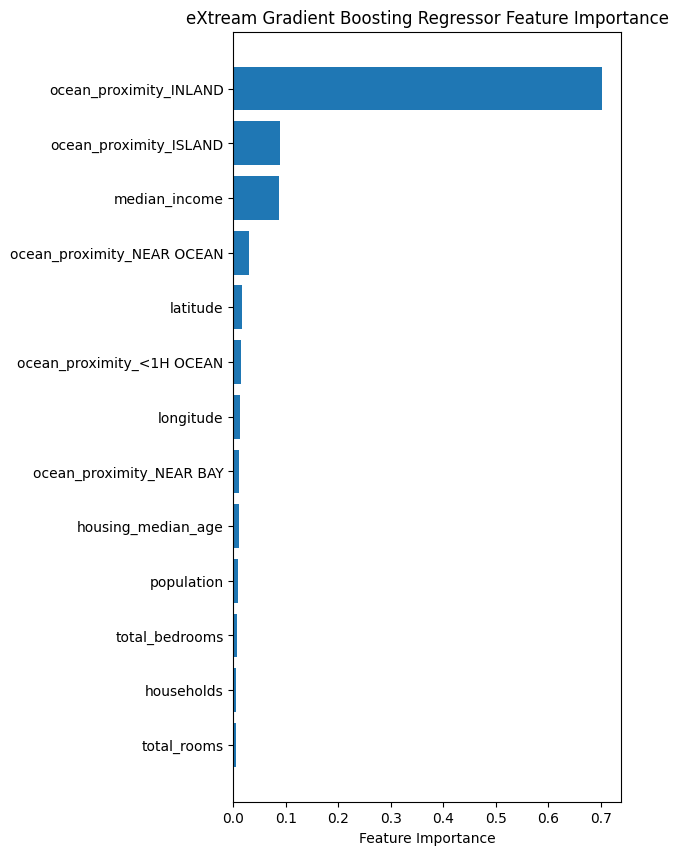

In [9]:
# Create a subplot with desired aspect ratio
fig, ax = plt.subplots(figsize=(5, 10))  # Adjust the size here (width, height)

# Plot feature importance
importances = best_xgbr_model.feature_importances_
indices = np.argsort(importances)[::-1]
ax.barh(range(X_train.shape[1]), importances[indices], align='center')
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels([X_train.columns[i] for i in indices])
ax.invert_yaxis()  # Invert y-axis to have the most important feature at the top
ax.set_xlabel('Feature Importance')
ax.set_title('eXtream Gradient Boosting Regressor Feature Importance')

plt.show()